<a href="https://www.kaggle.com/code/heejae177/unetr0214?scriptVersionId=119213757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import math
import torch
import torchvision 
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import Tensor
import random
from tqdm import tqdm

In [2]:

IMAGE_SIZE = (128,128) 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Data불러오기, Preprocessing

In [4]:
images = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/image")
masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/train/mask")

In [5]:
len(images)

16932

In [6]:
v_images = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/image")
v_masks = os.listdir("../input/lung-mask-image-dataset/ChestXray/val/mask")

In [7]:
masks.sort()
images.sort()
v_masks.sort()
v_images.sort()

In [8]:
import random

i = random.randint(0,len(v_images)-1)
sample_img = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/image",v_images[i])))
sample_mask = np.asarray(Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/mask",v_masks[i])))
print(sample_img.shape, sample_mask.shape)

(512, 512, 4) (512, 512, 3)


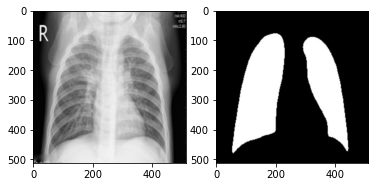

In [9]:
plt.subplot(1,2,1)
plt.imshow(sample_img[:,:,:3]) #rgba to rgb

plt.subplot(1,2,2)
plt.imshow(sample_mask)

plt.show()

In [10]:
#학습할 수 있는 형태로 dataloader에 올리기

In [11]:
#Image Augmentation

In [12]:
class TensorData(Dataset):

    def __init__(self, path="../input/lung-mask-image-dataset/ChestXray", val=False, aug=False):
        
        split = "train"
        if val:
            split = "val"
        
        self.root = os.path.join(path, split)
        self.image_paths = os.listdir(os.path.join(path, split, "image"))
        self.mask_paths = os.listdir(os.path.join(path, split, "mask"))
        
        if aug:
            self.transform = transforms.Compose([
                                transforms.Resize((128, 128)), 
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.ToTensor(),
                            ])
            self.transform2 = transforms.Compose([
                                transforms.Resize((128, 128)), 
                                transforms.ToTensor(),
                            ])
        else:
            self.transform = transforms.Compose([
                                transforms.Resize((128, 128)), 
                                transforms.ToTensor(),
                            ])
            self.transform2 = self.transform
        
    def __getitem__(self, index):
        
        x_data = Image.open(os.path.join(self.root, "image", self.image_paths[index])).convert('L')
        y_data = Image.open(os.path.join(self.root, "mask", self.mask_paths[index])).convert('L')

        x_data = self.transform(x_data)
        y_data = self.transform2(y_data)

        x_data = torch.FloatTensor(x_data)
        y_data = torch.FloatTensor(y_data)
        return x_data, y_data

    def __len__(self):
        return len(self.image_paths)

In [13]:
train_data = TensorData(aug=True, val=False)
train_loader = DataLoader(train_data, batch_size = 32)
val_data = TensorData(aug=False, val=True)
val_loader = DataLoader(val_data, batch_size = 64)

In [14]:
len(train_data)

16932

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [16]:
images.shape

torch.Size([32, 1, 128, 128])

In [17]:
# Multi Head Attention, Transformer 참조 출처 : https://hongl.tistory.com/235#Multi Head attention, 

In [17]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 486.0 kB/s eta 0:00:00 0:00:01


In [18]:
import einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 256, num_heads: int = 8, dropout: float = 0.2):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor):
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2] 
        
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [19]:
class Embedding(nn.Module):
    def __init__(self, input_shape, patch_size=16, emb_size=256):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = 1 # 흑백 이미지이므로
        self.patch_number = int((input_shape[-1] * input_shape[-2]) / (patch_size * patch_size)) # HxW 를 pxp 로 나눔 (H/p * W/p 이므로)
        self.emb_size = emb_size
        self.patch_emb = nn.Conv2d(in_channels=self.in_channels, out_channels=self.emb_size,
                                          kernel_size=self.patch_size, stride=self.patch_size) # Linearly embed image to tokens
        self.position_emb = nn.Parameter(torch.zeros(1, self.patch_number, self.emb_size)) # Learnable

    def forward(self, x):
        x = self.patch_emb(x)
        b,n,h,w = x.shape
        x = x.view(b, n, h*w).transpose(-1, -2)
        
        # batch, embed_dim, height/patch, width/patch
        embedding = x + self.position_emb
        
        return embedding

class FeedForward(nn.Sequential):
    def __init__(self, emb_size: int = 256, expansion: int=4, drop_p: float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class ResidualAdd(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res=x
        x = self.fn(x, **kwargs)
        x+=res
        return x
    
class Transformer(nn.Module):
    def __init__(self, emb_size=256, num_heads=8, expansion=4, drop_p=0.,out_layers=[3,6,9,12]):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(12):
            self.layers.append(nn.ModuleList([
                ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size,num_heads,drop_p),
                nn.Dropout(drop_p)
                )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForward(emb_size, expansion, drop_p),
                nn.Dropout(drop_p)
                ))]
            ))
        self.out_layers = out_layers
    def forward(self,x):
        output = []
        
        for num_layers, (mha,feedforward) in enumerate(self.layers):
            x = mha(x) + x
            x = feedforward(x) + x
            if num_layers+1 in self.out_layers:
                output.append(x)
        
        return output
        
        

In [20]:
#Unetr architecture

In [21]:
class one_conv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        if kernel_size ==1:
            padding_size=0
        elif kernel_size ==3:
            padding_size=1
            
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=padding_size)

    def forward(self, x):
        return self.conv(x)

class Yellow_conv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            one_conv(in_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.conv(x)
    
class Green_deconv(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)
        
    def forward(self, x):
        return self.conv(x)

    
class Blue_deconv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            Green_deconv(in_planes, out_planes),
            one_conv(out_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.conv(x)    

class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 128), input_dim=1, output_dim=1, 
                 emb_size=256, patch_size=16, num_heads=8):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.emb_size = emb_size
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.w, self.h = img_shape[0]/patch_size,img_shape[1]/patch_size

        self.embedding = Embedding(input_shape=img_shape)
        self.transformer = Transformer()
        
        self.out_z0 = nn.Sequential(Yellow_conv(input_dim, 8),Yellow_conv(8, 16))

        self.out_z3 = nn.Sequential(Blue_deconv(emb_size, 32),Blue_deconv(32, 32),Blue_deconv(32, 32))

        self.out_z6 = nn.Sequential(Blue_deconv(emb_size, 64),Blue_deconv(64, 64))
       
        self.out_z9 = Blue_deconv(emb_size, 128)
        
        self.up_tomeet_z9 = Green_deconv(emb_size, 128)
        
        self.up_tomeet_z6 = nn.Sequential(Yellow_conv(256, 64),Yellow_conv(64, 64),Green_deconv(64, 64))
        
        self.up_tomeet_z3 =  nn.Sequential(Yellow_conv(128, 32),Yellow_conv(32, 32),Green_deconv(32, 32))
        
        self.up_tomeet_top = nn.Sequential(Yellow_conv(64, 16),Yellow_conv(16, 16),Green_deconv(16, 16))

        self.top = nn.Sequential(Yellow_conv(32, 16),Yellow_conv(16, 16),one_conv(16, output_dim, 1))

    def forward(self, x):
        #x.shape [32,1,128,128]
        z3, z6, z9, z12 = self.transformer(self.embedding(x))
        
        #z3.shape (b, w*h, dim)
        z3 = z3.reshape(-1, self.emb_size, int(self.w), int(self.h))
        z6 = z6.reshape(-1, self.emb_size, int(self.w), int(self.h))
        z9 = z9.reshape(-1, self.emb_size, int(self.w), int(self.h))
        z12 = z12.reshape(-1, self.emb_size, int(self.w), int(self.h))
        #z3.shape(b, dim, w,h)

        z12,z9 = self.up_tomeet_z9(z12), self.out_z9(z9)
        
        z9 = self.up_tomeet_z6(torch.cat([z12, z9], dim=1))
        
        z6 = self.out_z6(z6)
        z6 = self.up_tomeet_z3(torch.cat([z9, z6], dim=1))
        
        z3 = self.out_z3(z3)
        z3 = self.up_tomeet_top(torch.cat([z6, z3], dim=1))
        
        z0= x
        z0 = self.out_z0(z0)
        output = self.top(torch.cat([z3, z0], dim=1))
        return output
        

In [22]:
model = UNETR(img_shape=IMAGE_SIZE, input_dim=1, output_dim=1, 
              emb_size=256, patch_size=16, num_heads=8)
model = model.to(DEVICE)


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


def dice_loss(pred, target, smooth = 1e-5):
    # binary cross entropy loss
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='mean')
    
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    
    # dice coefficient
    dice = 2.0 * (intersection + smooth) / (union + smooth)
    
    # dice loss
    dice_loss = 1.0 - dice
    
    # total loss
    loss = bce + dice_loss
    
    return loss.mean()

In [ ]:
#모델 학습 및 평가 

In [24]:
loss_ = []
val_loss_ = []
n_epochs = 10
n = len(train_loader)
cur_best = torch.Tensor([float("Inf")])
for epoch in range(n_epochs):
    running_loss = 0.0
    for data in tqdm(train_loader): 
        inputs, values = data
        inputs, values = inputs.to(DEVICE), values.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss= dice_loss(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        
    running_mean = running_loss/n
    loss_.append(running_mean)
    print(f"Train Loss Running Mean: {running_mean:.3f}")
    
    with torch.no_grad():
        val_loss = 0.0
        m = len(val_loader)
        for val_data in val_loader:
            inputs, values = val_data
            inputs, values = inputs.to(DEVICE), values.to(DEVICE)

            outputs = model(inputs)
            loss= dice_loss(outputs, values)

            val_loss += loss.item()
    val_running_mean = val_loss / m
    val_loss_.append(val_running_mean)
    print(f"Val Loss Running Mean: {val_running_mean:.3f}")
    
    if val_running_mean < cur_best:
        cur_best = val_running_mean
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, "Best_model.pt")

100%|██████████| 530/530 [08:47<00:00,  1.01it/s]


Train Loss Running Mean: 1.154
Val Loss Running Mean: 1.062


100%|██████████| 530/530 [04:50<00:00,  1.82it/s]


Train Loss Running Mean: 1.002
Val Loss Running Mean: 0.943


100%|██████████| 530/530 [04:51<00:00,  1.82it/s]


Train Loss Running Mean: 0.899
Val Loss Running Mean: 0.856


100%|██████████| 530/530 [04:52<00:00,  1.81it/s]


Train Loss Running Mean: 0.820
Val Loss Running Mean: 0.790


100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Train Loss Running Mean: 0.760
Val Loss Running Mean: 0.739


100%|██████████| 530/530 [04:50<00:00,  1.82it/s]


Train Loss Running Mean: 0.717
Val Loss Running Mean: 0.705


100%|██████████| 530/530 [04:50<00:00,  1.82it/s]


Train Loss Running Mean: 0.687
Val Loss Running Mean: 0.682


100%|██████████| 530/530 [04:53<00:00,  1.81it/s]


Train Loss Running Mean: 0.667
Val Loss Running Mean: 0.667


100%|██████████| 530/530 [04:49<00:00,  1.83it/s]


Train Loss Running Mean: 0.655
Val Loss Running Mean: 0.657


100%|██████████| 530/530 [04:53<00:00,  1.80it/s]


Train Loss Running Mean: 0.647
Val Loss Running Mean: 0.652


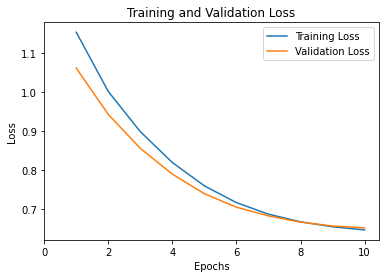

In [25]:
epochs = list(range(1, n_epochs+1))
 
plt.plot(epochs, loss_, label='Training Loss')
plt.plot(epochs, val_loss_, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, n_epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

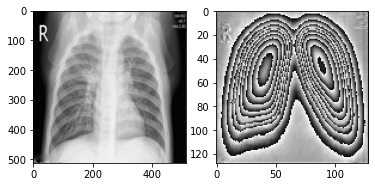

In [26]:
from torchvision.transforms.functional import to_pil_image

preprocess = transforms.Compose([
                                transforms.Resize((128, 128)), 
                                transforms.ToTensor(),
                            ])

# sample_img, sample_mask
with torch.no_grad():
    sample_input = preprocess(Image.fromarray(sample_img).convert("L"))
    sample_input = sample_input.to(DEVICE).unsqueeze(0) # batch dimension
    sample_output = model(sample_input)
    sample_output = sample_output.cpu()[0] # batch dimension
    sample_pil = to_pil_image(sample_output)

plt.subplot(1,2,1)
plt.imshow(sample_img[:,:,:3])

plt.subplot(1,2,2)
plt.imshow(sample_pil, cmap='gray')

plt.show()